# Data Preprocessing

### Imports and Load Data

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("../input/updated_named_data.csv", parse_dates=["datum"], index_col="datum")

# Display first rows
data.head()

,Antiinflammatory,Antirheumatic,Analgesics,Antipyretics,Psycholeptics,Sedatives,Bronchodilators,Antihistamines
datum,,,,,,,,
2014-01-05,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
2014-01-12,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2014-01-19,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
2014-01-26,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
2014-02-02,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0


### Handle Missing Values

In [4]:
# Fill missing values with rolling median (window = 3 chosen for smoother correction)
data_filled = data.copy()
data_filled = data_filled.fillna(data_filled.rolling(window=3, min_periods=1).median())

data_filled.head()

,Antiinflammatory,Antirheumatic,Analgesics,Antipyretics,Psycholeptics,Sedatives,Bronchodilators,Antihistamines
datum,,,,,,,,
2014-01-05,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
2014-01-12,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2014-01-19,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
2014-01-26,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
2014-02-02,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0


### Remove Duplicates

In [5]:
# Drop duplicates if any
data_no_duplicates = data_filled.drop_duplicates()

print(f"Removed {len(data_filled) - len(data_no_duplicates)} duplicates")

Removed 0 duplicates


### Seasonal Decomposition (for Outlier Detection)

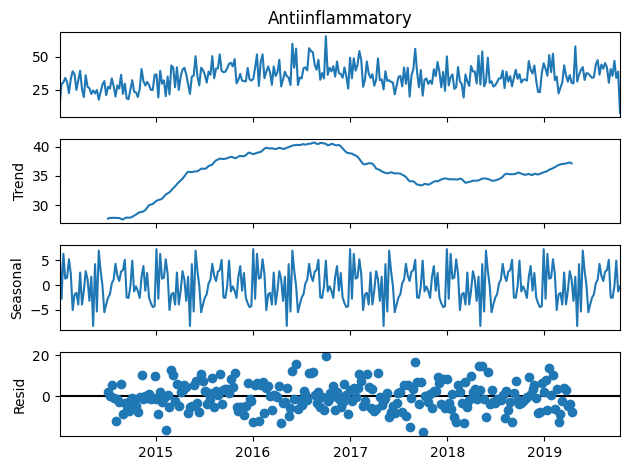

In [6]:
# Decompose for each column
decomposition_results = {}
for col in data_no_duplicates.columns:
    decomposition = seasonal_decompose(data_no_duplicates[col], model='additive', period=52)  # weekly data -> yearly seasonality
    decomposition_results[col] = decomposition
    
    # Optional: plot one column to visualize
    if col == data_no_duplicates.columns[0]:
        decomposition.plot()
        plt.show()

### Outlier Detection with IQR on Residuals

In [31]:

import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Load your data
data = pd.read_csv("../input/updated_named_data.csv")

# Ensure datum is datetime
data['datum'] = pd.to_datetime(data['datum'])

# Set datum as index for time series analysis
data = data.set_index('datum')

# Select all numeric columns (excluding the index)
numeric_cols = data.select_dtypes(include='number').columns

for col in numeric_cols:
    # Seasonal decomposition
    decomposition = seasonal_decompose(data[col], model="additive", period=7)
    
    # Compute residual
    residual = decomposition.resid.dropna()
    
    # IQR method for outlier detection
    Q1 = residual.quantile(0.25)
    Q3 = residual.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Boolean mask for outliers
    is_outlier = (residual < lower_bound) | (residual > upper_bound)
    
    # Rolling median for outlier replacement
    rolling_median = residual.rolling(window=3, min_periods=1).median()
    
    # Replace outliers with rolling median
    residual_fixed = residual.copy()
    residual_fixed[is_outlier] = rolling_median[is_outlier]
    
    # Reconstruct cleaned series
    cleaned_series = decomposition.trend + decomposition.seasonal + residual_fixed
    
    # Add cleaned column to DataFrame
    data[col + "_cleaned"] = cleaned_series
    
# Save to CSV
data_reset.to_csv("../input/named_data_cleaned.csv", index=False)
print("✅ Cleaned file saved to input/named_data_cleaned.csv")

✅ Cleaned file saved to input/named_data_cleaned.csv
